In [17]:
import os
import mne
import PyQt6
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import StratifiedKFold

from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import false_discovery_control

%matplotlib qt

In [2]:
folders = os.listdir('bipolar/')

fldr2label = {
    'control (160)': 0,
    'Биполярка депресс тип (35)': 4,
    'Биполярка маниакальный тип (36)': 5,
    'мания_психи(30)': 6,
    'циклотимия (13)': 7,
    'depressed_32-0(22)': 1,
    'depressed_32-1(44)': 2,
    'depressed_32-2(22)': 3,
}
og_files = []
zg_files = []
og_labels = []
zg_labels = []
for fldr in folders:
    pth =  'bipolar/' + fldr
    og_pths = [x for x in os.listdir(pth) if x.lower().endswith('.edf') and ('og.' in x.lower() or 'ог.' in x.lower() or '_ог' in x.lower() or 'eo' in x.lower())]
    zg_pths = [x for x in os.listdir(pth) if x.lower().endswith('.edf') and ('zg.' in x.lower() or 'зг.' in x.lower() or '_зг' in x.lower() or 'ec' in x.lower() or 'fon.' in x.lower() or 'eс' in x.lower())]
    for f in og_pths:
        og_files.append(pth + '/' + f)
        og_labels.append(fldr2label[fldr])
    for f in zg_pths:
        zg_files.append(pth + '/' + f)
        zg_labels.append(fldr2label[fldr])

print(f'Number of files for open eyes: {len(og_files)}')
print(f'Number of files for closed eyes: {len(zg_files)}')

Number of files for open eyes: 363
Number of files for closed eyes: 363


## Fractal dimensionality

In [3]:
from mne_features.univariate import compute_higuchi_fd

In [54]:
channels2use = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'F7', 'F8', 'T3', 'T4', 'C3', 'Cz', 'C4', 'T5', 'T6', 'P3', 'Pz', 'P4', 'O1', 'O2']
name_pairs = [('Fp1', 'Fp2'), ('F3', 'F4'), ('F7', 'F8'), ('C3', 'C4'), ('T3', 'T4'), ('P3', 'P4'), ('T5', 'T6'), ('O1', 'O2')]
idx_pairs = [(0, 1), (2, 4), (5, 6), (9, 11), (7, 8), (14, 16), (12, 13), (17, 18)]

def get_data_from_sample(sample):
    data = None
    sample = sample.filter(l_freq=1, h_freq=30, method='iir', verbose=False)
    channels = sample.ch_names
    to_drop = channels[19:]
    sample.drop_channels(to_drop)

    new_idx = []
    skip = False
    for ch in channels2use:
        found = False
        for k in range(19):
            if ch in channels[k]:
                new_idx.append(k)
                found = True
                break
        if not found:
            skip = True
            break
    if not skip:
        s_freq = int(sample.info['sfreq'])
        data = sample.get_data()[new_idx]
    return data

def compute_hfd(data, s_freq):
    # psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=s_freq, fmin=4, fmax=7, n_fft=1024, n_per_seg=s_freq, verbose=False)
    # psd_avg = np.mean(psd, axis=1)
    hfd = compute_higuchi_fd(data)
    return hfd

hfds_og, hfds_zg = [], []
labels_og, labels_zg = [], []
for i in tqdm(range(len(og_files))):
    path_og = og_files[i]
    path_zg = zg_files[i]
    try:
        sample_og = mne.io.read_raw_edf(path_og, verbose=False, preload=True)
    except Exception as e:
        print(f'skipped {path_og}')
        continue

    sample_zg = mne.io.read_raw_edf(path_zg, verbose=False, preload=True)
    s_freq_og = int(sample_og.info['sfreq'])
    s_freq_zg = int(sample_zg.info['sfreq'])
    data_og = get_data_from_sample(sample_og)
    data_zg = get_data_from_sample(sample_zg)
    if data_og is None or data_zg is None:
        print(f'skipped {path_og} and {path_zg}')
    else:
        max_len = max(data_og.shape[1], data_zg.shape[1])
        data_og = data_og[:, :max_len]
        data_zg = data_zg[:, :max_len]

        hfd_og = compute_hfd(data_og, s_freq_og)
        hfd_zg = compute_hfd(data_zg, s_freq_zg)
        hfds_og.append(hfd_og)
        hfds_zg.append(hfd_zg)
        labels_og.append(og_labels[i])
        labels_zg.append(zg_labels[i])

  0%|          | 0/363 [00:00<?, ?it/s]

skipped bipolar/control (160)/BORUTTO_JANNA_VLADIMIROVNA_48_EO_free.edf and bipolar/control (160)/BORUTTO_JANNA_VLADIMIROVNA_48_EC_free.edf
skipped bipolar/control (160)/MANUILOVA_ELENA_55_EO_free.edf and bipolar/control (160)/MANUILOVA_ELENA_55_EC_free.edf
skipped bipolar/control (160)/Martinenko_45_EO.edf and bipolar/control (160)/Martinenko_45_EC_free.edf
skipped bipolar/control (160)/Skopincev_20_EO_free.edf


In [55]:
hfds_og = np.array(hfds_og)
hfds_zg = np.array(hfds_zg)
labels_og = np.array(labels_og)
labels_zg = np.array(labels_zg)

In [24]:
false_discovery_control(stats.shapiro(np.array(hfds_og), axis=0)[1])

array([1.97042369e-01, 1.15007669e-02, 2.78867799e-01, 4.47340213e-02,
       4.43026645e-02, 4.88909155e-01, 4.47340213e-02, 4.47340213e-02,
       1.00439038e-01, 8.42394391e-03, 4.13654059e-03, 7.83878194e-05,
       1.33173331e-15, 1.32786122e-09, 2.30017568e-03, 1.52739617e-03,
       2.26997344e-05, 4.47340213e-02, 6.85711054e-02])

In [25]:
false_discovery_control(stats.shapiro(np.array(hfds_zg), axis=0)[1])

array([6.23038485e-09, 2.84023729e-10, 2.18353361e-09, 1.62618298e-07,
       8.66755262e-09, 5.46648485e-08, 3.81706424e-09, 7.13256482e-07,
       5.90811479e-06, 8.12276451e-10, 1.40572404e-09, 5.17400899e-11,
       2.44687624e-18, 1.67933982e-17, 1.70895276e-12, 4.00268535e-11,
       3.79124049e-16, 1.92673127e-10, 2.68680294e-13])

Seems like they are not normally distributed, thus, I will use Mann-Whitney U-test.

### Open vs closed eyes

#### All electrodes

In [30]:
mw = stats.mannwhitneyu(np.array(hfds_og), np.array(hfds_zg))[1]
print(false_discovery_control(mw))

[1.08659730e-38 2.74893629e-42 4.16625859e-42 2.74893629e-42
 1.16818906e-43 2.96727873e-41 1.47514386e-42 9.23215257e-27
 5.05214039e-33 3.00140400e-31 1.40349717e-38 3.95938592e-37
 8.58084340e-37 4.27725142e-44 2.96727873e-41 4.27725142e-44
 1.46527028e-45 6.97533487e-40 4.20507025e-41]


In [45]:
mw = stats.mannwhitneyu(np.array(hfds_og), np.array(hfds_zg), alternative='greater')[1]
print(false_discovery_control(mw))

print(f'MAPE by channels: {np.mean(np.abs(hfds_og - hfds_zg) / hfds_og, axis=0) * 100}')

[5.43298652e-39 1.37446815e-42 2.08312929e-42 1.37446815e-42
 5.84094532e-44 1.48363937e-41 7.37571932e-43 4.61607628e-27
 2.52607020e-33 1.50070200e-31 7.01748587e-39 1.97969296e-37
 4.29042170e-37 2.13862571e-44 1.48363937e-41 2.13862571e-44
 7.32635138e-46 3.48766743e-40 2.10253512e-41]
MAPE by channels: [6.64518698 7.09615112 6.67046605 6.14305566 6.68949514 6.6731826
 6.95754987 6.50076435 6.24285337 5.71776771 5.90256885 5.85261238
 7.05363066 7.38651454 6.49860091 6.34692445 6.55006378 7.35559852
 7.12583097]


#### Combined by zones

In [46]:
zone2ids = {'frontal': [0, 1, 2, 3, 4, 5, 6], 'temporal': [7, 8, 12, 13], 'central': [9, 10, 11], 'parietal': [14, 15, 16], 'occipital': [17, 18]}

mws = []
for zone in zone2ids.keys():
    print(f'ZONE: {zone}')
    zone_og = np.mean(hfds_og[:, zone2ids[zone]], axis=1)
    zone_zg = np.mean(hfds_zg[:, zone2ids[zone]], axis=1)
    mw = stats.mannwhitneyu(zone_og, zone_zg)[1]
    mws.append(mw)
    print(f'MAPE: {np.mean(np.abs(zone_og - zone_zg) / zone_og, axis=0) * 100 :.3f}')
    print()

print(false_discovery_control(mws))

ZONE: frontal
MAPE: 6.570

ZONE: temporal
MAPE: 6.538

ZONE: central
MAPE: 5.719

ZONE: parietal
MAPE: 6.404

ZONE: occipital
MAPE: 7.162

[1.67348318e-45 1.50879052e-40 1.16058753e-37 1.60206538e-45
 1.54981670e-41]


In [47]:
zone2ids = {'frontal': [0, 1, 2, 3, 4, 5, 6], 'temporal': [7, 8, 12, 13], 'central': [9, 10, 11], 'parietal': [14, 15, 16], 'occipital': [17, 18]}

mws = []
for zone in zone2ids.keys():
    zone_og = np.mean(hfds_og[:, zone2ids[zone]], axis=1)
    zone_zg = np.mean(hfds_zg[:, zone2ids[zone]], axis=1)
    mw = stats.mannwhitneyu(zone_og, zone_zg, alternative='greater')[1]
    mws.append(mw)

print(false_discovery_control(mws))

[8.36741591e-46 7.54395258e-41 5.80293767e-38 8.01032690e-46
 7.74908352e-42]


#### Left vs right vs center

In [48]:
side2ids = {'right': [1, 4, 6, 8, 11, 13, 16, 18], 'left': [0, 2, 5, 7, 9, 12, 14, 17], 'center': [3, 10, 15]}
mws = []
for side in side2ids.keys():
    side_og = np.mean(hfds_og[:, side2ids[side]], axis=1)
    side_zg = np.mean(hfds_zg[:, side2ids[side]], axis=1)
    mw = stats.mannwhitneyu(side_og, side_zg, alternative='greater')[1]
    mws.append(mw)
    print(f'MAPE: {np.mean(np.abs(side_og - side_zg) / side_og, axis=0) * 100 :.3f}')

print(false_discovery_control(mws))

MAPE: 6.581
MAPE: 6.458
MAPE: 6.025
[2.71430623e-47 2.48949680e-43 1.21363121e-45]


#### Avg

In [50]:
avg_og = np.mean(hfds_og, axis=1)
avg_zg = np.mean(hfds_zg, axis=1)
mw = stats.mannwhitneyu(avg_og, avg_zg)[1]
print(mw)
print(f'MAPE: {np.mean(np.abs(avg_og - avg_zg) / avg_og, axis=0) * 100 :.3f}')

9.542281993486255e-47
MAPE: 6.425


### By diagnoses

Open eyes

In [63]:
# simple mean of all channels
groups = []

for diag, id in fldr2label.items():
    grp = hfds_og[labels_og == id].mean(axis=1)
    groups.append(grp)

print(stats.kruskal(*groups))

KruskalResult(statistic=22.48018102574708, pvalue=0.002098542072566335)


In [71]:
diags = list(fldr2label.keys())
pvals = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        pvals.append(stats.mannwhitneyu(groups[i], groups[j])[1])

pvals_corrected = false_discovery_control(pvals)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}: pvalue {pvals_corrected[cnt]:.3f}')
        cnt += 1

control (160) vs Биполярка депресс тип (35): pvalue 0.396
control (160) vs Биполярка маниакальный тип (36): pvalue 0.107
control (160) vs мания_психи(30): pvalue 0.107
control (160) vs циклотимия (13): pvalue 0.289
control (160) vs depressed_32-0(22): pvalue 0.883
control (160) vs depressed_32-1(44): pvalue 0.017
control (160) vs depressed_32-2(22): pvalue 0.911
Биполярка депресс тип (35) vs Биполярка маниакальный тип (36): pvalue 0.533
Биполярка депресс тип (35) vs мания_психи(30): pvalue 0.465
Биполярка депресс тип (35) vs циклотимия (13): pvalue 0.155
Биполярка депресс тип (35) vs depressed_32-0(22): pvalue 0.396
Биполярка депресс тип (35) vs depressed_32-1(44): pvalue 0.387
Биполярка депресс тип (35) vs depressed_32-2(22): pvalue 0.543
Биполярка маниакальный тип (36) vs мания_психи(30): pvalue 0.883
Биполярка маниакальный тип (36) vs циклотимия (13): pvalue 0.017
Биполярка маниакальный тип (36) vs depressed_32-0(22): pvalue 0.301
Биполярка маниакальный тип (36) vs depressed_32-1(44

In [79]:
# larger classes
label_map = {0: 0, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 4}
new_classes = {'control': 0, 'depressed': 1, 'bipolar': 2, 'mania': 3, 'cyclotimia': 4}
new_labels_og = np.array([label_map[i] for i in labels_og])

groups = []
for diag, id in new_classes.items():
    grp = hfds_og[new_labels_og == id].mean(axis=1)
    groups.append(grp)

print(stats.kruskal(*groups))

KruskalResult(statistic=14.402605085959646, pvalue=0.006115005841194129)


In [74]:
diags = list(new_classes.keys())
pvals = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        pvals.append(stats.mannwhitneyu(groups[i], groups[j])[1])

pvals_corrected = false_discovery_control(pvals)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}: pvalue {pvals_corrected[cnt]:.3f}')
        cnt += 1

control vs depressed: pvalue 0.065
control vs bipolar: pvalue 0.054
control vs mania: pvalue 0.054
control vs cyclotimia: pvalue 0.147
depressed vs bipolar: pvalue 0.917
depressed vs mania: pvalue 0.917
depressed vs cyclotimia: pvalue 0.054
bipolar vs mania: pvalue 0.864
bipolar vs cyclotimia: pvalue 0.030
mania vs cyclotimia: pvalue 0.025


In [94]:
# separate zones
zone2ids = {'frontal': [0, 1, 2, 3, 4, 5, 6], 'temporal': [7, 8, 12, 13], 'central': [9, 10, 11], 'parietal': [14, 15, 16], 'occipital': [17, 18]}

groups = {x: [] for x in zone2ids.keys()}
for diag, id in new_classes.items():
    grp = hfds_og[new_labels_og == id]
    for zone in zone2ids.keys():
        zone_og = np.mean(grp[:, zone2ids[zone]], axis=1)
        groups[zone].append(zone_og)

pvals = []
for zone in zone2ids.keys():
    pvals.append(stats.kruskal(*groups[zone])[1])
pvals_corrected = false_discovery_control(pvals)

cnt = 0
for zone in zone2ids.keys():
    print(f'{zone}: pvalue {pvals_corrected[cnt]}')
    cnt += 1

frontal: pvalue 0.058641002419835844
temporal: pvalue 0.0017451550817324899
central: pvalue 0.058641002419835844
parietal: pvalue 0.02179622164717914
occipital: pvalue 0.006932663525004479


In [99]:
diags = list(new_classes.keys())

pvals_unwrapped = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        for zone in zone2ids.keys():
            pvals_unwrapped.append(stats.mannwhitneyu(groups[zone][i], groups[zone][j])[1])

pvals_corrected = false_discovery_control(pvals_unwrapped)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}')
        for zone in zone2ids.keys():
            print(f'\t{zone}: pvalue {pvals_corrected[cnt]:.3f}')
            cnt += 1
        print()

control vs depressed
	frontal: pvalue 0.139
	temporal: pvalue 0.037
	central: pvalue 0.305
	parietal: pvalue 0.331
	occipital: pvalue 0.037

control vs bipolar
	frontal: pvalue 0.170
	temporal: pvalue 0.023
	central: pvalue 0.272
	parietal: pvalue 0.139
	occipital: pvalue 0.021

control vs mania
	frontal: pvalue 0.190
	temporal: pvalue 0.018
	central: pvalue 0.743
	parietal: pvalue 0.177
	occipital: pvalue 0.080

control vs cyclotimia
	frontal: pvalue 0.257
	temporal: pvalue 0.555
	central: pvalue 0.138
	parietal: pvalue 0.125
	occipital: pvalue 0.901

depressed vs bipolar
	frontal: pvalue 0.955
	temporal: pvalue 0.955
	central: pvalue 0.975
	parietal: pvalue 0.955
	occipital: pvalue 0.895

depressed vs mania
	frontal: pvalue 0.955
	temporal: pvalue 0.595
	central: pvalue 0.903
	parietal: pvalue 0.973
	occipital: pvalue 0.955

depressed vs cyclotimia
	frontal: pvalue 0.093
	temporal: pvalue 0.075
	central: pvalue 0.037
	parietal: pvalue 0.021
	occipital: pvalue 0.139

bipolar vs mania


Closed eyes

In [75]:
# simple mean of all channels
groups = []

for diag, id in fldr2label.items():
    grp = hfds_zg[labels_zg == id].mean(axis=1)
    groups.append(grp)

print(stats.kruskal(*groups))

KruskalResult(statistic=36.261678449565544, pvalue=6.4698198187972935e-06)


In [76]:
diags = list(fldr2label.keys())
pvals = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        pvals.append(stats.mannwhitneyu(groups[i], groups[j])[1])

pvals_corrected = false_discovery_control(pvals)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}: pvalue {pvals_corrected[cnt]:.3f}')
        cnt += 1

control (160) vs Биполярка депресс тип (35): pvalue 0.141
control (160) vs Биполярка маниакальный тип (36): pvalue 0.030
control (160) vs мания_психи(30): pvalue 0.020
control (160) vs циклотимия (13): pvalue 0.299
control (160) vs depressed_32-0(22): pvalue 0.880
control (160) vs depressed_32-1(44): pvalue 0.000
control (160) vs depressed_32-2(22): pvalue 0.723
Биполярка депресс тип (35) vs Биполярка маниакальный тип (36): pvalue 0.791
Биполярка депресс тип (35) vs мания_психи(30): pvalue 0.723
Биполярка депресс тип (35) vs циклотимия (13): pvalue 0.070
Биполярка депресс тип (35) vs depressed_32-0(22): pvalue 0.299
Биполярка депресс тип (35) vs depressed_32-1(44): pvalue 0.141
Биполярка депресс тип (35) vs depressed_32-2(22): pvalue 0.563
Биполярка маниакальный тип (36) vs мания_психи(30): pvalue 0.588
Биполярка маниакальный тип (36) vs циклотимия (13): pvalue 0.028
Биполярка маниакальный тип (36) vs depressed_32-0(22): pvalue 0.141
Биполярка маниакальный тип (36) vs depressed_32-1(44

In [85]:
# larger classes
label_map = {0: 0, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 4}
new_classes = {'control': 0, 'depressed': 1, 'bipolar': 2, 'mania': 3, 'cyclotimia': 4}
new_labels_zg = np.array([label_map[i] for i in labels_zg])

groups = []
for diag, id in new_classes.items():
    grp = hfds_zg[new_labels_zg == id].mean(axis=1)
    groups.append(grp)

print(stats.kruskal(*groups))

KruskalResult(statistic=22.382405069445834, pvalue=0.0001681779443054103)


In [78]:
diags = list(new_classes.keys())
pvals = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        pvals.append(stats.mannwhitneyu(groups[i], groups[j])[1])

pvals_corrected = false_discovery_control(pvals)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}: pvalue {pvals_corrected[cnt]:.3f}')
        cnt += 1

control vs depressed: pvalue 0.010
control vs bipolar: pvalue 0.010
control vs mania: pvalue 0.010
control vs cyclotimia: pvalue 0.305
depressed vs bipolar: pvalue 0.837
depressed vs mania: pvalue 0.585
depressed vs cyclotimia: pvalue 0.012
bipolar vs mania: pvalue 0.585
bipolar vs cyclotimia: pvalue 0.012
mania vs cyclotimia: pvalue 0.010


In [100]:
# separate zones
zone2ids = {'frontal': [0, 1, 2, 3, 4, 5, 6], 'temporal': [7, 8, 12, 13], 'central': [9, 10, 11], 'parietal': [14, 15, 16], 'occipital': [17, 18]}

groups = {x: [] for x in zone2ids.keys()}
for diag, id in new_classes.items():
    grp = hfds_zg[new_labels_zg == id]
    for zone in zone2ids.keys():
        zone_zg = np.mean(grp[:, zone2ids[zone]], axis=1)
        groups[zone].append(zone_zg)

pvals = []
for zone in zone2ids.keys():
    pvals.append(stats.kruskal(*groups[zone])[1])
pvals_corrected = false_discovery_control(pvals)

cnt = 0
for zone in zone2ids.keys():
    print(f'{zone}: pvalue {pvals_corrected[cnt]}')
    cnt += 1

frontal: pvalue 0.015615423341096023
temporal: pvalue 2.989826833002926e-05
central: pvalue 0.00024757152501673433
parietal: pvalue 7.510633387550245e-06
occipital: pvalue 0.00024757152501673433


In [101]:
diags = list(new_classes.keys())

pvals_unwrapped = []
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        for zone in zone2ids.keys():
            pvals_unwrapped.append(stats.mannwhitneyu(groups[zone][i], groups[zone][j])[1])

pvals_corrected = false_discovery_control(pvals_unwrapped)
cnt = 0
for i in range(len(diags)):
    for j in range(i + 1, len(diags)):
        print(f'{diags[i]} vs {diags[j]}')
        for zone in zone2ids.keys():
            print(f'\t{zone}: pvalue {pvals_corrected[cnt]:.3f}')
            cnt += 1
        print()

control vs depressed
	frontal: pvalue 0.049
	temporal: pvalue 0.002
	central: pvalue 0.012
	parietal: pvalue 0.005
	occipital: pvalue 0.004

control vs bipolar
	frontal: pvalue 0.044
	temporal: pvalue 0.005
	central: pvalue 0.014
	parietal: pvalue 0.012
	occipital: pvalue 0.023

control vs mania
	frontal: pvalue 0.044
	temporal: pvalue 0.002
	central: pvalue 0.012
	parietal: pvalue 0.004
	occipital: pvalue 0.116

control vs cyclotimia
	frontal: pvalue 0.551
	temporal: pvalue 0.662
	central: pvalue 0.190
	parietal: pvalue 0.020
	occipital: pvalue 0.269

depressed vs bipolar
	frontal: pvalue 0.920
	temporal: pvalue 0.794
	central: pvalue 0.949
	parietal: pvalue 0.802
	occipital: pvalue 0.574

depressed vs mania
	frontal: pvalue 0.574
	temporal: pvalue 0.459
	central: pvalue 0.534
	parietal: pvalue 0.679
	occipital: pvalue 0.631

depressed vs cyclotimia
	frontal: pvalue 0.116
	temporal: pvalue 0.027
	central: pvalue 0.012
	parietal: pvalue 0.002
	occipital: pvalue 0.002

bipolar vs mania


## Alpha rhythm

In [11]:
channels2use = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'F7', 'F8', 'T3', 'T4', 'C3', 'Cz', 'C4', 'T5', 'T6', 'P3', 'Pz', 'P4', 'O1', 'O2']
name_pairs = [('Fp1', 'Fp2'), ('F3', 'F4'), ('F7', 'F8'), ('C3', 'C4'), ('T3', 'T4'), ('P3', 'P4'), ('T5', 'T6'), ('O1', 'O2')]
idx_pairs = [(0, 1), (2, 4), (5, 6), (9, 11), (7, 8), (14, 16), (12, 13), (17, 18)]

def get_data_from_sample(sample):
    data = None
    sample = sample.filter(l_freq=1, h_freq=30, method='iir', verbose=False)
    channels = sample.ch_names
    to_drop = channels[19:]
    sample.drop_channels(to_drop)

    new_idx = []
    skip = False
    for ch in channels2use:
        found = False
        for k in range(19):
            if ch in channels[k]:
                new_idx.append(k)
                found = True
                break
        if not found:
            skip = True
            break
    if not skip:
        s_freq = int(sample.info['sfreq'])
        data = sample.get_data()[new_idx]
    return data

def compute_features(data, s_freq):
    psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=s_freq, fmin=4, fmax=7, n_fft=1024, n_per_seg=s_freq, verbose=False)
    psd_avg = np.mean(psd, axis=1)
    hfd = compute_higuchi_fd(data)
    return psd_avg, hfd

psds_og, psds_zg, hfds_og, hfds_zg = [], [], [], []
for i in tqdm(range(len(og_files))):
    path_og = og_files[i]
    path_zg = zg_files[i]
    try:
        sample_og = mne.io.read_raw_edf(path_og, verbose=False, preload=True)
    except Exception as e:
        print(f'skipped {path_og}')
        continue

    sample_zg = mne.io.read_raw_edf(path_zg, verbose=False, preload=True)
    s_freq_og = int(sample_og.info['sfreq'])
    s_freq_zg = int(sample_zg.info['sfreq'])
    data_og = get_data_from_sample(sample_og)
    data_zg = get_data_from_sample(sample_zg)
    if data_og is None or data_zg is None:
        print(f'skipped {path_og} and {path_zg}')
    else:
        max_len = max(data_og.shape[1], data_zg.shape[1])
        data_og = data_og[:, :max_len]
        data_zg = data_zg[:, :max_len]

        psd_og, hfd_og = compute_features(data_og, s_freq_og)
        psd_zg, hfd_zg = compute_features(data_zg, s_freq_zg)
        psds_og.append(psd_og)
        psds_zg.append(psd_zg)
        hfds_og.append(hfd_og)
        hfds_zg.append(hfd_zg)

  0%|          | 0/363 [00:00<?, ?it/s]

skipped bipolar/control (160)/BORUTTO_JANNA_VLADIMIROVNA_48_EO_free.edf and bipolar/control (160)/BORUTTO_JANNA_VLADIMIROVNA_48_EC_free.edf
skipped bipolar/control (160)/MANUILOVA_ELENA_55_EO_free.edf and bipolar/control (160)/MANUILOVA_ELENA_55_EC_free.edf
skipped bipolar/control (160)/Martinenko_45_EO.edf and bipolar/control (160)/Martinenko_45_EC_free.edf
skipped bipolar/control (160)/Skopincev_20_EO_free.edf


In [12]:
res = ttest_rel(psds_og, psds_zg)
print(res)
print(false_discovery_control(res.pvalue))

TtestResult(statistic=array([ -2.37527585,  -2.64677823,  -9.78234967,  -9.5081534 ,
       -10.17601132,  -7.03192517,  -7.79268506,  -8.11715985,
        -9.08267121, -11.22991724, -11.28521802, -10.73381752,
       -10.70498283,  -7.22095949, -12.21401935, -12.77412394,
       -11.67210667,  -7.52703919,  -9.45082605]), pvalue=array([1.80618836e-02, 8.48514523e-03, 3.48856981e-20, 2.90961960e-19,
       1.56622236e-21, 1.03864413e-11, 7.19027035e-14, 7.75622233e-15,
       7.29466987e-18, 2.84014274e-25, 1.78695732e-25, 1.72748886e-23,
       2.18725842e-23, 3.12196704e-12, 6.43079709e-29, 4.77273920e-31,
       6.79018809e-27, 4.25067126e-13, 4.51373938e-19]), df=array([358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358,
       358, 358, 358, 358, 358, 358]))
[1.80618836e-02 8.95654219e-03 7.36475849e-20 5.52827725e-19
 3.71977810e-21 1.16083756e-11 9.75822404e-14 1.13360172e-14
 1.15498940e-17 1.07925424e-24 8.48804729e-25 5.47038138e-23
 5.93684429e-23 3.70733586e-12

In [13]:
res = ttest_rel(hfds_og, hfds_zg)
print(res)
print(false_discovery_control(res.pvalue))

TtestResult(statistic=array([22.08985553, 24.35446241, 23.33318379, 24.58511318, 25.49794263,
       24.44745944, 26.06980109, 18.54832372, 21.4877622 , 21.2320166 ,
       23.17261384, 23.37083746, 22.758932  , 25.31509733, 24.14292541,
       26.45486685, 26.56391298, 24.23812618, 24.53728297]), pvalue=array([7.80875465e-69, 5.83220545e-78, 7.22832906e-74, 7.03327450e-79,
       1.71288618e-82, 2.48406503e-78, 9.75119973e-85, 2.65815214e-54,
       2.22314079e-66, 2.46780020e-65, 3.20749006e-73, 5.09824951e-74,
       1.50500170e-71, 9.00709815e-82, 4.07660099e-77, 3.06340933e-86,
       1.15318954e-86, 1.69835210e-77, 1.09013944e-78]), df=array([358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358,
       358, 358, 358, 358, 358, 358]))
[9.27289615e-69 1.23124337e-77 1.05644809e-73 2.22720359e-78
 8.13620934e-82 5.89965444e-78 6.17575983e-84 2.65815214e-54
 2.48468676e-66 2.60490021e-65 4.35302223e-73 8.07222840e-74
 1.90633548e-71 3.42269730e-81 7.04140171e-77 2.91023886

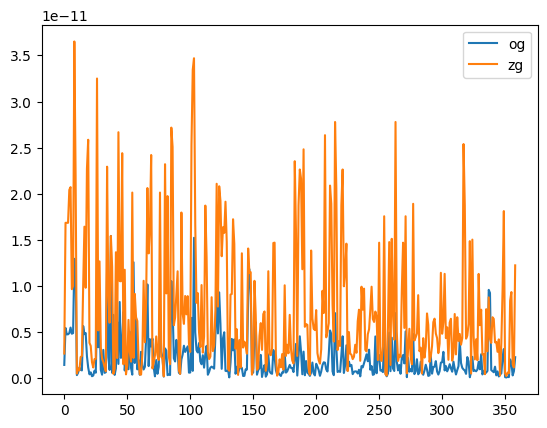

In [61]:
%matplotlib inline

idx = 11
plt.plot(list(range(len(psds_og))), [x[idx] for x in psds_og], label='og')
plt.plot(list(range(len(psds_zg))), [x[idx] for x in psds_zg], label='zg')
plt.legend()
plt.show()

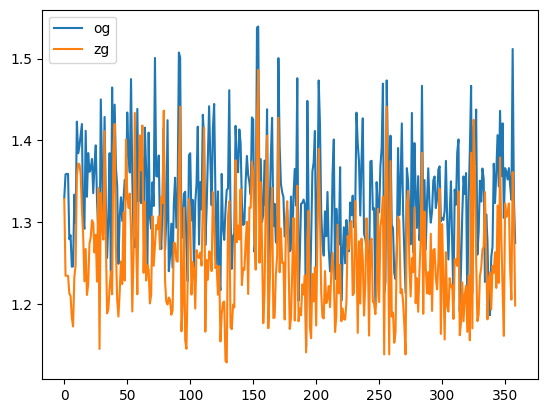

In [57]:
%matplotlib inline

idx = 3
plt.plot(list(range(len(psds_og))), [x[idx] for x in hfds_og], label='og')
plt.plot(list(range(len(psds_zg))), [x[idx] for x in hfds_zg], label='zg')
plt.legend()
plt.show()